In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+--------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|    simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|                date|            time|temperature_2m (°C)|precipitation (mm)|rain

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------+---------+---------+--------+
|    simp_date| latitude|longitude| borough|
+-------------+---------+---------+--------+
|2021-09-11 09|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08| 40.86816|-73.83148|   BRONX|
|2021-12-14 21| 40.67172| -73.8971|BROOKLYN|
+-------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('month', split(df['simp_date'], '-').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+-----+
|latitude          |longitude |borough      |month|
+------------------+----------+-------------+-----+
|40.667202         |-73.8665  |BROOKLYN     |09   |
|40.86816          |-73.83148 |BRONX        |12   |
|40.67172          |-73.8971  |BROOKLYN     |12   |
|40.75144          |-73.97397 |MANHATTAN    |12   |
|40.675883999999996|-73.75577 |QUEENS       |12   |
|40.66684          |-73.78941 |QUEENS       |12   |
|40.68158          |-73.97463 |BROOKLYN     |12   |
|40.65068          |-73.95881 |BROOKLYN     |12   |
|40.87262          |-73.904686|BRONX        |12   |
|40.748917         |-73.993546|MANHATTAN    |12   |
|40.75373          |-73.88505 |QUEENS       |12   |
|40.63165          |-74.08762 |STATEN ISLAND|12   |
|40.623104         |-73.95809 |BROOKLYN     |12   |
|40.66576          |-73.9845  |BROOKLYN     |12   |
|40.687534         |-73.9775  |BROOKLYN     |12   |
|40.710957         |-73.951126|BROOKLYN     |12   |
|40.81813   

### BRONX_spring

In [5]:
spring = df1.rdd.filter(lambda x: x[3]=='03' or x[3]=='04' or x[3]=='05')
spring = spring.filter(lambda x: x[2]=="BRONX")
spring = spring.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
spring = spring.map(lambda x: [x[0], x[1]])

loc_spring = spring.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_spring)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.843906| -73.92413|[40.843906,-73.92...|
| 40.89481| -73.86183|[40.89481,-73.86183]|
|40.861862| -73.91275|[40.861862,-73.91...|
| 40.88839| -73.84666|[40.88839,-73.84666]|
|40.844425|  -73.8639|[40.844425,-73.8639]|
|40.833965|  -73.8629|[40.833965,-73.8629]|
|40.829777| -73.85055|[40.829777,-73.85...|
|40.831055|-73.905846|[40.831055,-73.90...|
| 40.86173| -73.91182|[40.86173,-73.91182]|
| 40.82707| -73.87075|[40.82707,-73.87075]|
| 40.83578|-73.871445|[40.83578,-73.871...|
| 40.85713|  -73.8808| [40.85713,-73.8808]|
|40.857418| -73.89996|[40.857418,-73.89...|
|40.856434|-73.886826|[40.856434,-73.88...|
| 40.87151| -73.87057|[40.87151,-73.87057]|
| 40.88399| -73.82641|[40.88399,-73.82641]|
|40.857365| -73.84657|[40.857365,-73.84...|
|   40.815| -73.89402|  [40.815,-73.89402]|
|40.890076|-73.819855|[40.890076,-73.81...|
|40.817696|-73.922615|[40.817696

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.843906| -73.92413|[40.843906,-73.92...|         5|
| 40.89481| -73.86183|[40.89481,-73.86183]|         7|
|40.861862| -73.91275|[40.861862,-73.91...|        16|
| 40.88839| -73.84666|[40.88839,-73.84666]|         7|
|40.844425|  -73.8639|[40.844425,-73.8639]|         0|
|40.833965|  -73.8629|[40.833965,-73.8629]|        12|
|40.829777| -73.85055|[40.829777,-73.85...|         6|
|40.831055|-73.905846|[40.831055,-73.90...|         5|
| 40.86173| -73.91182|[40.86173,-73.91182]|        16|
| 40.82707| -73.87075|[40.82707,-73.87075]|        12|
| 40.83578|-73.871445|[40.83578,-73.871...|        12|
| 40.85713|  -73.8808| [40.85713,-73.8808]|         1|
|40.857418| -73.89996|[40.857418,-73.89...|         1|
|40.856434|-73.886826|[40.856434,-73.88...|         1|
| 40.87151| -73.87057|[40.87151,-73.87057]|        17|
| 40.88399

In [7]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.85647423 -73.86354219]
[ 40.86045115 -73.89287825]
[ 40.81870634 -73.89262908]
[ 40.90391569 -73.90048443]
[ 40.82450497 -73.82283821]
[ 40.83116301 -73.91671705]
[ 40.8264695  -73.85426965]
[ 40.89426557 -73.85526957]
[ 40.8519151  -73.79027958]
[ 40.70167879 -73.94814098]
[ 40.87923025 -73.90469096]
[ 40.81178339 -73.91911982]
[ 40.83275155 -73.87228917]
[ 40.87642248 -73.83222439]
[ 40.87432161 -73.85276574]
[ 40.58108025 -74.1082665 ]
[ 40.85089372 -73.90940929]
[ 40.87817611 -73.87605559]
[ 40.84043082 -73.89143062]
[ 40.84538931 -73.84077385]


Text(0.5,1,'BRONX_spring')

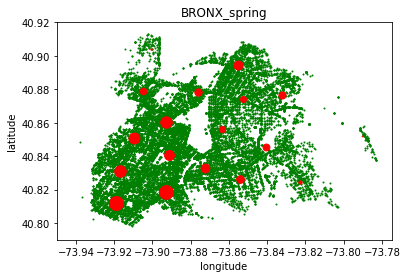

In [8]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.xlim([-73.95, -73.775])
plt.ylim([40.79, 40.92])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BRONX_spring")

### BRONX_summer

In [9]:
summer = df1.rdd.filter(lambda x: x[3]=='06' or x[3]=='07' or x[3]=='08')
summer = summer.filter(lambda x: x[2]=="BRONX")
summer = summer.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
summer = summer.map(lambda x: [x[0], x[1]])

loc_summer = summer.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_summer)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.878128| -73.86944|[40.878128,-73.86...|
| 40.87122| -73.83709|[40.87122,-73.83709]|
|40.843384| -73.88987|[40.843384,-73.88...|
| 40.86514|-73.801544|[40.86514,-73.801...|
|40.822456|-73.868065|[40.822456,-73.86...|
|40.896385| -73.87246|[40.896385,-73.87...|
|  40.8502|  -73.8302|  [40.8502,-73.8302]|
| 40.81358| -73.89385|[40.81358,-73.89385]|
| 40.85755|-73.882835|[40.85755,-73.882...|
| 40.83604| -73.92222|[40.83604,-73.92222]|
| 40.87037| -73.87052|[40.87037,-73.87052]|
|40.850304| -73.85137|[40.850304,-73.85...|
| 40.88048| -73.83832|[40.88048,-73.83832]|
| 40.84939| -73.85622|[40.84939,-73.85622]|
|40.846138| -73.86172|[40.846138,-73.86...|
| 40.86094|-73.822586|[40.86094,-73.822...|
| 40.86404| -73.89245|[40.86404,-73.89245]|
|40.886806| -73.85216|[40.886806,-73.85...|
|40.892624|-73.859924|[40.892624,-73.85...|
|40.852425| -73.86873|[40.852425

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.878128| -73.86944|[40.878128,-73.86...|         8|
| 40.87122| -73.83709|[40.87122,-73.83709]|        11|
|40.843384| -73.88987|[40.843384,-73.88...|        17|
| 40.86514|-73.801544|[40.86514,-73.801...|        11|
|40.822456|-73.868065|[40.822456,-73.86...|         2|
|40.896385| -73.87246|[40.896385,-73.87...|        12|
|  40.8502|  -73.8302|  [40.8502,-73.8302]|         9|
| 40.81358| -73.89385|[40.81358,-73.89385]|        13|
| 40.85755|-73.882835|[40.85755,-73.882...|         1|
| 40.83604| -73.92222|[40.83604,-73.92222]|        16|
| 40.87037| -73.87052|[40.87037,-73.87052]|         8|
|40.850304| -73.85137|[40.850304,-73.85...|        19|
| 40.88048| -73.83832|[40.88048,-73.83832]|        11|
| 40.84939| -73.85622|[40.84939,-73.85622]|        19|
|40.846138| -73.86172|[40.846138,-73.86...|        14|
| 40.86094

In [11]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.65913691 -73.95279773]
[ 40.86170833 -73.89723616]
[ 40.82667054 -73.85989567]
[ 40.8273128  -73.90686743]
[ 40.8956263  -73.84767515]
[ 40.87310434 -73.85463555]
[ 40.82945927 -73.81205449]
[ 40.84771619 -73.90300171]
[ 40.87688277 -73.87769098]
[ 40.83754463 -73.83404278]
[ 40.81373973 -73.92263797]
[ 40.87570936 -73.83119788]
[ 40.8916185  -73.86165372]
[ 40.8187638  -73.88959396]
[ 40.85394918 -73.86716281]
[ 40.81019126 -73.90817972]
[ 40.83938446 -73.91961817]
[ 40.83765297 -73.88172851]
[ 40.88563638 -73.90412024]
[ 40.84725027 -73.84955748]


Text(0.5,1,'BRONX_summer')

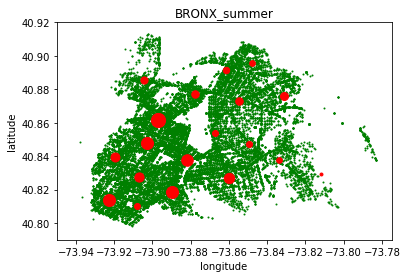

In [12]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.xlim([-73.95, -73.775])
plt.ylim([40.79, 40.92])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BRONX_summer")

### BRONX_fall

In [13]:
fall = df1.rdd.filter(lambda x: x[3]=='09' or x[3]=='10' or x[3]=='11')
fall = fall.filter(lambda x: x[2]=="BRONX")
fall = fall.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
fall = fall.map(lambda x: [x[0], x[1]])

loc_fall = fall.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_fall)
new_df.show()

+------------------+----------+--------------------+
|          latitude| longitude|            features|
+------------------+----------+--------------------+
|          40.87645|-73.848175|[40.87645,-73.848...|
|         40.826767|-73.888855|[40.826767,-73.88...|
|         40.832916| -73.92939|[40.832916,-73.92...|
|40.807536999999996|  -73.8798|[40.8075369999999...|
|         40.817795| -73.89319|[40.817795,-73.89...|
|          40.90222| -73.85589|[40.90222,-73.85589]|
|          40.84964| -73.89661|[40.84964,-73.89661]|
|         40.846313| -73.92385|[40.846313,-73.92...|
|          40.80789|-73.852844|[40.80789,-73.852...|
|         40.836094|-73.883995|[40.836094,-73.88...|
|          40.87739|  -73.8665| [40.87739,-73.8665]|
|         40.868164| -73.90054|[40.868164,-73.90...|
|          40.86418| -73.90119|[40.86418,-73.90119]|
|         40.875942| -73.83304|[40.875942,-73.83...|
|         40.810387| -73.91521|[40.810387,-73.91...|
|         40.838573| -73.86077|[40.838573,-73.

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------------------+----------+
|          latitude| longitude|            features|prediction|
+------------------+----------+--------------------+----------+
|          40.87645|-73.848175|[40.87645,-73.848...|         6|
|         40.826767|-73.888855|[40.826767,-73.88...|         4|
|         40.832916| -73.92939|[40.832916,-73.92...|        10|
|40.807536999999996|  -73.8798|[40.8075369999999...|         4|
|         40.817795| -73.89319|[40.817795,-73.89...|         4|
|          40.90222| -73.85589|[40.90222,-73.85589]|        14|
|          40.84964| -73.89661|[40.84964,-73.89661]|         3|
|         40.846313| -73.92385|[40.846313,-73.92...|        10|
|          40.80789|-73.852844|[40.80789,-73.852...|        15|
|         40.836094|-73.883995|[40.836094,-73.88...|         9|
|          40.87739|  -73.8665| [40.87739,-73.8665]|        17|
|         40.868164| -73.90054|[40.868164,-73.90...|        16|
|          40.86418| -73.90119|[40.86418

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.84046657 -73.84827315]
[ 40.81981839 -73.91952345]
[ 40.87845129 -73.87849006]
[ 40.8397522  -73.89575706]
[ 40.81905845 -73.89163803]
[ 40.80799135 -73.91528494]
[ 40.86816128 -73.84013438]
[ 40.88375658 -73.83309626]
[ 40.6795951 -74.0097971]
[ 40.83533688 -73.87386061]
[ 40.83846881 -73.9175811 ]
[ 40.88488414 -73.9042388 ]
[ 40.8613146  -73.86400478]
[ 40.8257937  -73.82387077]
[ 40.8967999  -73.85027222]
[ 40.82424109 -73.85871355]
[ 40.86023984 -73.89137011]
[ 40.88696909 -73.86049116]
[ 40.85599502 -73.90704723]
[ 40.84790861 -73.82329358]


Text(0.5,1,'BRONX_fall')

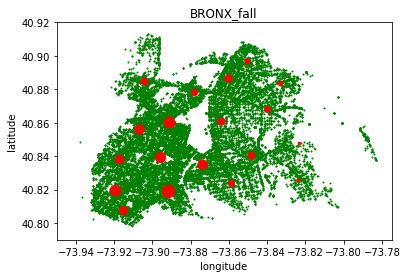

In [16]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.xlim([-73.95, -73.775])
plt.ylim([40.79, 40.92])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BRONX_fall")

### BRONX_winter

In [17]:
winter = df1.rdd.filter(lambda x: x[3]=='12' or x[3]=='01' or x[3]=='02')
winter = winter.filter(lambda x: x[2]=="BRONX")
winter = winter.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
winter = winter.map(lambda x: [x[0], x[1]])

loc_winter = winter.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_winter)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
| 40.86816| -73.83148|[40.86816,-73.83148]|
| 40.87262|-73.904686|[40.87262,-73.904...|
| 40.81813|-73.910126|[40.81813,-73.910...|
|40.854935| -73.85822|[40.854935,-73.85...|
|40.839443| -73.90436|[40.839443,-73.90...|
|  40.8176| -73.90373| [40.8176,-73.90373]|
|40.843464|   -73.836| [40.843464,-73.836]|
|40.880135|-73.873085|[40.880135,-73.87...|
|40.835835|-73.877365|[40.835835,-73.87...|
|40.815754|-73.883934|[40.815754,-73.88...|
| 40.84835| -73.85573|[40.84835,-73.85573]|
|40.842007| -73.85755|[40.842007,-73.85...|
|40.847816| -73.89663|[40.847816,-73.89...|
| 40.81152| -73.89448|[40.81152,-73.89448]|
| 40.89687| -73.87645|[40.89687,-73.87645]|
|40.824066|-73.908714|[40.824066,-73.90...|
|40.831184|-73.913284|[40.831184,-73.91...|
| 40.86173| -73.91182|[40.86173,-73.91182]|
| 40.84274|-73.854485|[40.84274,-73.854...|
| 40.86832| -73.83317|[40.86832,

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 40.86816| -73.83148|[40.86816,-73.83148]|         2|
| 40.87262|-73.904686|[40.87262,-73.904...|        18|
| 40.81813|-73.910126|[40.81813,-73.910...|         3|
|40.854935| -73.85822|[40.854935,-73.85...|         5|
|40.839443| -73.90436|[40.839443,-73.90...|        17|
|  40.8176| -73.90373| [40.8176,-73.90373]|         3|
|40.843464|   -73.836| [40.843464,-73.836]|        14|
|40.880135|-73.873085|[40.880135,-73.87...|        10|
|40.835835|-73.877365|[40.835835,-73.87...|         8|
|40.815754|-73.883934|[40.815754,-73.88...|        13|
| 40.84835| -73.85573|[40.84835,-73.85573]|         5|
|40.842007| -73.85755|[40.842007,-73.85...|        14|
|40.847816| -73.89663|[40.847816,-73.89...|        17|
| 40.81152| -73.89448|[40.81152,-73.89448]|        13|
| 40.89687| -73.87645|[40.89687,-73.87645]|        10|
|40.824066

In [19]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.81184777 -73.92114581]
[ 40.89563154 -73.85566776]
[ 40.86554693 -73.83332436]
[ 40.81996921 -73.90658612]
[ 40.85523395 -73.90777704]
[ 40.8569903  -73.86346395]
[ 40.83635257 -73.91835842]
[ 40.82527273 -73.85615689]
[ 40.83450683 -73.87244718]
[ 40.90423497 -73.90069613]
[ 40.87859763 -73.87698551]
[ 40.82913174 -73.82118573]
[ 40.86053819 -73.89117635]
[ 40.81930598 -73.88888002]
[ 40.84176001 -73.84349949]
[ 40.8836211  -73.83419965]
[ 40.8761456  -73.85499075]
[ 40.84103904 -73.89377526]
[ 40.87936058 -73.90433709]
[ 40.6283532 -73.980062 ]


Text(0.5,1,'BRONX_winter')

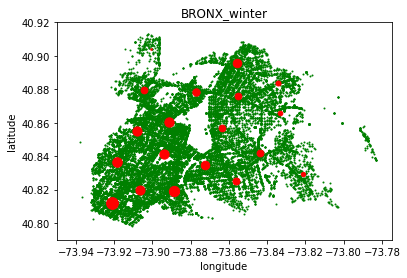

In [20]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-73.95 and i[1]<-73.775:
        if i[0]>40.78 and i[0]<40.92:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/200)
            idx+=1
            
plt.xlim([-73.95, -73.775])
plt.ylim([40.79, 40.92])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BRONX_winter")